In [ ]:
import os

import numpy as np
import pandas as pd
from scipy.stats import median_absolute_deviation
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import optuna
from sklearn.preprocessing import StandardScaler
import random
random_state = 1234
from sklearn.metrics import roc_auc_score
import os
from pathlib import Path
import tensorflow as tf
from tensorflow import keras 
import tensorflow_addons as tfa
from keras.regularizers import l2
import xgboost as xgb
from sklearn.linear_model import SGDClassifier
import datetime
parent_dir = Path(os.getcwd()).parent
cross_validation_dir = os.path.join(parent_dir, "Data", "train_test_indices.npy")
dataset = "MSK_Impact_train"
# dataset = "BCAST_train"
data_dir = os.path.join(parent_dir, "Data" , dataset)
train_test_indices = np.load(cross_validation_dir, allow_pickle = True)

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Machine-learning training/testing

In [ ]:
def build_kneigh_model(n_neighbors, X, y):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X, y)
    
    return model

def build_NN_model(X_train, y_train, X_val, y_val, input_shape=(96,), n_hidden_layers=2, n_hidden_nodes=16, 
                   activation="relu", learning_rate=0.001, weight_decay = 0, l2_kernel = 0.01, l2_bias = 0.01,
                   class_weight_0 = 1, class_weight_1 = 1):
    # optimizer parameters
    loss = "binary_crossentropy"
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay = weight_decay)
    metrics = keras.metrics.AUC(name='auc')
    
    # ANN model
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    for _ in range(n_hidden_layers):
        model.add(keras.layers.Dense(n_hidden_nodes, activation=activation, kernel_regularizer=l2(l2_kernel), bias_regularizer=l2(l2_bias)))
    
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    
    # optimizer
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    model.fit(X_train, y_train, 
                      validation_data=(X_val, y_val), 
                      epochs=1000, batch_size=32, verbose=0,
                      class_weight= {0 : class_weight_0, 1 : class_weight_1},
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_auc', patience=10)])
    
    return model

def build_logReg_model(X_train, y_train):
    clf = SGDClassifier(random_state=random_state,loss="log", penalty="l2").fit(X_train, y_train)
    return clf

def build_XGBoost_model(X_train, y_train, X_val, y_val, eta, max_depth, min_child_weight, gamma, subsample, colsample_bytree, reg_alpha, n_estimators, reg_lambda, scale_pos_weight):
    param = {
     'learning_rate': eta,
     'n_estimators': int(n_estimators),
     'max_depth': int(max_depth),
     'min_child_weight': min_child_weight,
     'gamma':gamma,
     'subsample':subsample,
     'colsample_bytree':colsample_bytree,
     'reg_alpha' : reg_alpha,
     'reg_lambda': reg_lambda,
     'eval_metric':'auc',
     'nthread':4,
     'scale_pos_weight':scale_pos_weight,
     'seed':27}
    clf = xgb.XGBClassifier(**param)

    clf.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=20,
            verbose=False)
    
    return clf
def list_files_in_dir(dirname):
    dir_files = list()
    for root, _, files in os.walk(dirname):
        for file in files:
            dir_files.append(os.path.join(root, file))
    
    return dir_files

def scale_rows(X):
    return X.div(X.sum(axis=1), axis=0)

def dataset_generator(data_dir, y_col):
    
    for datafile in list_files_in_dir(data_dir):
        data = pd.read_csv(datafile)
        X = data.iloc[:, :96]
        y = (data[y_col]).astype(np.int_)
        X.columns = X.columns.str.replace('[', '').str.replace(']', '').str.replace('>', '')
        X = scale_rows(X)
        yield X, y

def train_val_test_generator_default(data_dir, y_col, test_frac=0.1):
    
    val_frac = test_frac/(1.0 - test_frac)
    
    for X, y in dataset_generator(data_dir, y_col):
        fold_data = list()

        
        for train_val_index, test_index in train_test_indices:
            X_test, y_test = X.iloc[test_index, :], y.iloc[test_index]
            X_train, X_val, y_train, y_val = train_test_split(
                X.iloc[train_val_index,:], y.iloc[train_val_index], 
                test_size=val_frac, 
                random_state=random_state, 
                stratify=y.iloc[train_val_index]
            )
#             print(train_val_index, test_index)
            
            #X_train, X_val, X_test = scale_columns(X_train, X_val, X_test)
            fold_data.append(((X_train, y_train), 
                              (X_val, y_val), 
                              (X_test, y_test)))
            
        yield fold_data

def select_model (model_name, X_train, y_train, X_val, y_val, kwargs):
    model = None
    if (model_name == 'KNN'):
        model = build_kneigh_model(int(kwargs['n_neighbors']), X_train, y_train)
    elif (model_name == 'NN'):
        model = build_NN_model(X_train, y_train, X_val, y_val, input_shape=kwargs['input_shape'], 
                               n_hidden_layers=kwargs['n_hidden_layers'], n_hidden_nodes=kwargs['n_hidden_nodes'], 
                               activation=kwargs['activation'], learning_rate=kwargs['learning_rate'], 
                               weight_decay=kwargs['weight_decay'], l2_kernel=kwargs['l2_kernel'], l2_bias=kwargs['l2_bias'],
                               class_weight_0 = kwargs['class_weight_0'], class_weight_1 = kwargs['class_weight_1'])
    elif (model_name == 'LR'):
        model = build_logReg_model(X_train, y_train)
    elif (model_name == 'XGBoost'):
        model = build_XGBoost_model(X_train, y_train, X_val, y_val, eta=kwargs['eta'], max_depth=kwargs['max_depth'], 
                                    min_child_weight=kwargs['min_child_weight'], gamma=kwargs['gamma'], subsample=kwargs['subsample']
                                    ,colsample_bytree=kwargs['colsample_bytree'], reg_alpha=kwargs['reg_alpha'], 
                                    n_estimators=kwargs['n_estimators'], reg_lambda=kwargs['reg_lambda'], 
                                    scale_pos_weight=kwargs['scale_pos_weight'])
        
    return model
 

def compute_mlp_performance(data_dir=data_dir, y_col='is_sig3', model_name='NN', **kwargs):
    print(model_name, " model selected")
    aucs = list()
    models = list()
    predictions = list()
    
    for folds_data in train_val_test_generator_default(data_dir, y_col=y_col):
        fold_aucs = list()
        fold_models = list()
        
        for fold_data in folds_data:
            # get data
            (X_train, y_train), (X_val, y_val), (X_test, y_test) = fold_data

            model = select_model(model_name = model_name, X_train = X_train, y_train=y_train, 
                                 X_val = X_val, y_val = y_val, kwargs = kwargs)
            
            if model_name=='NN':
                fold_aucs.append(roc_auc_score(y_test,  model.predict(X_test)))
                predictions.append((y_test, model.predict(X_test)))
            else:
                preds = [x[1] for x in model.predict_proba(X_test)]
                predictions.append((y_test, preds))
            
#                 preds = model.predict(X_test)
                fold_aucs.append(roc_auc_score(y_test, preds))
            fold_models.append(model)
            
        aucs.append(fold_aucs)
        models.append(fold_models)
        
    aucs = np.array(aucs)
    
    median_of_median_auc = np.median(np.median(aucs, axis=1))
    
    # Gets median index value for all the different samples (rows)  
    medianIndices = [indices[len(aucs[0])//2] for indices in np.argsort(aucs, axis=1)]
    medianValues = [values[index] for values, index in zip(aucs, medianIndices)]
    
    # Gets the file which contains the median of median value
    fileInd = np.argsort(medianValues)[len(medianValues)//2]
    
    median_of_median_model = models[fileInd][medianIndices[fileInd]]
    mad_of_mad_auc = median_absolute_deviation(median_absolute_deviation(aucs, axis=1))
    
#     return predictions 
    return median_of_median_auc, median_absolute_deviation(aucs, axis=1), median_of_median_model
#     return median_of_median_auc


    
    

### XGBoost Results

In [ ]:
# Threshold: 20% of Mutations 
XGB_auc_20, XGB_mad_20, XGB_model_20  = compute_mlp_performance(data_dir, model_name='XGBoost', n_folds=10, num_samples = 1, y_col = 'is_sig3_20', eta= 7.014002176195272e-07, 
                            max_depth=27, min_child_weight = 0.3744262575940115, gamma = 0.1807028624162206, subsample = 0.9367044934803391, 
                            colsample_bytree = 0.56763340675143, reg_alpha = 0.5287639745576873, n_estimators =  786, reg_lambda = 3.482869781553655, scale_pos_weight = 3.104245921259989)
print(XGB_auc_20, XGB_mad_20)

# Threshold: 10% of Mutations
XGB_auc_10, XGB_mad_10, XGB_model_10 = compute_mlp_performance(data_dir, model_name='XGBoost', n_folds=10, num_samples = 1, y_col = 'is_sig3_10', eta= 0.04941201151079784, 
                            max_depth=6, min_child_weight = 0.16583275317721513, gamma = 1.710610569779565, subsample = 0.6502161365069198, 
                            colsample_bytree = 0.5786109127644017, reg_alpha = 0.5596484894892493, n_estimators =  1494, reg_lambda = 2.241219360407485, scale_pos_weight = 1.62607735656732)
print(XGB_auc_10, XGB_mad_10)

# Threshold: 5% of Mutations 
XGB_auc_05, XGB_mad_05, XGB_model_05 = compute_mlp_performance(data_dir, model_name='XGBoost', n_folds=10, num_samples = 1, y_col = 'is_sig3_05', eta= 0.08973652247827073, 
                            max_depth=39, min_child_weight = 0.012250079894579408, gamma = 0.36463850626755556, subsample = 0.9630983383695453, 
                            colsample_bytree = 0.6812717117053958, reg_alpha = 0.1266287931693426, n_estimators =  630, reg_lambda = 0.005114708100679544, scale_pos_weight = 0.9286839537467326)
print(XGB_auc_05, XGB_mad_05)

# Threshold: 1% of Mutations 
XGB_auc_01, XGB_mad_01, XGB_model_01  = compute_mlp_performance(data_dir, model_name='XGBoost', n_folds=10, num_samples = 1, y_col = 'is_sig3_01', eta= 0.09890625080822577, 
                            max_depth=11, min_child_weight = 0.9544087090431423, gamma = 2.86571998910088, subsample = 0.8877178932315292, 
                            colsample_bytree = 0.30562815526313286, reg_alpha = 0.5237522651981981, n_estimators =  1300, reg_lambda = 0.5758395868030254, scale_pos_weight = 2.183537271028318)
print(XGB_auc_01, XGB_mad_01)


XGBoost  model selected
0.7679276906945175 [0.06934281]
XGBoost  model selected
0.6730769230769231 [0.04304306]
XGBoost  model selected
0.67309670781893 [0.05068203]
XGBoost  model selected
0.6459742875248488 [0.07239971]


In [ ]:
for data in dataset_generator(data_dir, y_col='is_sig3_20'):
    X,y = data
    X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.1, 
    random_state=random_state, 
    stratify=y)
    kwargs = {
        'eta':7.014002176195272e-07, 
        'max_depth':27, 
        'min_child_weight' : 0.3744262575940115, 
        'gamma' : 0.1807028624162206, 
        'subsample' : 0.9367044934803391, 
        'colsample_bytree' : 0.56763340675143, 
        'reg_alpha' : 0.5287639745576873, 
        'n_estimators' :  786, 
        'reg_lambda' : 3.482869781553655, 
        'scale_pos_weight' : 3.104245921259989
    }
    model = select_model(model_name = 'XGBoost', X_train = X_train, y_train=y_train, 
                                 X_val = X_val, y_val = y_val, kwargs = kwargs)

In [ ]:
model.save_model('XGBoost_20.json')

### XGBoost Model ROC Curve with Violin Plot

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

predictions = compute_mlp_performance(data_dir, model_name='XGBoost', n_folds=10, num_samples = 1, y_col = 'is_sig3_20', eta= 7.014002176195272e-07, 
                            max_depth=27, min_child_weight = 0.3744262575940115, gamma = 0.1807028624162206, subsample = 0.9367044934803391, 
                            colsample_bytree = 0.56763340675143, reg_alpha = 0.5287639745576873, n_estimators =  786, reg_lambda = 3.482869781553655, scale_pos_weight = 3.104245921259989)

y_test_total = list()
y_pred_total = list()
for fold in predictions:
    y_test, y_pred = fold
    y_test_total.extend(y_test)
    y_pred_total.extend(y_pred)
    

XGBoost  model selected


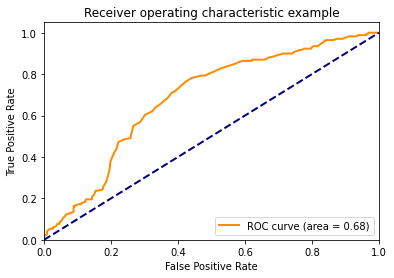

In [ ]:
# Compute ROC curve and ROC area
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test_total, y_pred_total)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()



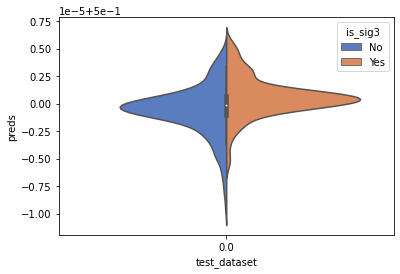

In [ ]:
# Generate a Violin Plot
violin_plot_data = pd.DataFrame()
violin_plot_data['is_sig3'] = ["Yes" if x == 1 else "No" for x in y_test_total]
violin_plot_data['preds'] = y_pred_total
violin_plot_data['test_dataset'] = np.zeros(len(y))
ax = sns.violinplot(x="test_dataset", y="preds", hue="is_sig3",
                    data=violin_plot_data, palette="muted", split=True)

### Neural Network Results

Note that due to random initialization of weights and biases, results will vary.

In [ ]:
# Threshold: 20% of Mutations
NN_auc_20, NN_mad_20, NN_model_20 = compute_mlp_performance(data_dir, model_name = 'NN', n_folds=10, input_shape=(96,), 
                        n_hidden_layers=1, n_hidden_nodes=224, 
                        activation="relu", learning_rate=0.014405369664987436, y_col='is_sig3_20', num_samples=1, 
                        weight_decay = 0.008844031348287134,l2_kernel =  0.0008442313215686649, l2_bias = 0.49960347582667186,
                        class_weight_0 = 3.6971304115389914, class_weight_1 = 3.2478186786138186)

print(NN_auc_20, NN_mad_20)

# # Threshold: 10% of Mutations 
# NN_auc_10, NN_mad_10, NN_model_10 = compute_mlp_performance(data_dir, model_name = 'NN', n_folds=10, input_shape=(96,), 
#                         n_hidden_layers=1, n_hidden_nodes=46, 
#                         activation="relu", learning_rate = 0.03888682338678942, y_col='is_sig3_10', num_samples=1, 
#                         weight_decay = 0.00320469659234629,l2_kernel = 0.01080815241478056, l2_bias = 0.04194271288714817,
#                         class_weight_0 = 1, class_weight_1 = 1)
# print(NN_auc_10, NN_mad_10)

# Threshold: 5% of Mutations 
# NN_auc_05, NN_mad_05, NN_model_05 = compute_mlp_performance(data_dir, model_name = 'NN', n_folds=10, input_shape=(96,), 
#                         n_hidden_layers=1, n_hidden_nodes=187, 
#                         activation="relu", learning_rate = 0.032196300179017756, y_col='is_sig3_05', num_samples=1, 
#                         weight_decay = 0.2901855215206835,l2_kernel = 0.19725045739870212, l2_bias = 0.1873649586337309,
#                         class_weight_0 = 2.7603554805968944, class_weight_1 = 0.012506845449285708)
# print(NN_auc_05, NN_mad_05)     
    
# Threshold: 1% of Mutations 
# NN_auc_01, NN_mad_01, NN_model_01 = compute_mlp_performance(data_dir, model_name = 'NN', n_folds=10, input_shape=(96,), 
#                         n_hidden_layers=1, n_hidden_nodes=29, 
#                         activation="sigmoid", learning_rate = 0.03546236755021929, y_col='is_sig3_01', num_samples=1, 
#                         weight_decay = 0,l2_kernel = 0, l2_bias = 0,
#                         class_weight_0 = 3.423500294070057, class_weight_1 = 0.24179751564250412)
# print(NN_auc_01, NN_mad_01)
                                               


NN  model selected
2/2 [==============================] - 0s 1ms/step
0.6784970238095238 [0.13029713]


In [ ]:
for data in dataset_generator(data_dir, y_col='is_sig3_20'):
    X,y = data
    X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.1, 
    random_state=random_state, 
    stratify=y)
    kwargs = {
        'input_shape':(96,1),
        'n_hidden_layers':1,
        'n_hidden_nodes':224,
        'activation':"relu",
        'learning_rate':0.014405369664987436,
        'y_col':'is_sig3_20',
        'num_samples':1,
        'weight_decay': 0.008844031348287134,
        'l2_kernel': 0.0008442313215686649,
        'l2_bias' : 0.49960347582667186,
        'class_weight_0' : 3.6971304115389914,
        'class_weight_1' : 3.2478186786138186
    }
    model = select_model(model_name = 'NN', X_train = X_train, y_train=y_train, 
                                 X_val = X_val, y_val = y_val, kwargs = kwargs)

In [ ]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, r"D:\NIH\mutational-spectrum-master\js\Models\NN")


In [ ]:
tfjs.converters.save_keras_model(NN_model_20, r"D:\NIH\mutational-spectrum-master\js\Models\NN")


In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

predictions = compute_mlp_performance(data_dir, model_name = 'NN', n_folds=10, input_shape=(96,), 
                        n_hidden_layers=1, n_hidden_nodes=224, 
                        activation="relu", learning_rate=0.014405369664987436, y_col='is_sig3_20', num_samples=1, 
                        weight_decay = 0.008844031348287134,l2_kernel =  0.0008442313215686649, l2_bias = 0.49960347582667186,
                        class_weight_0 = 3.6971304115389914, class_weight_1 = 3.2478186786138186)

y_test_total = list()
y_pred_total = list()
for fold in predictions:
    y_test, y_pred = fold
    y_test_total.extend(y_test)
    y_pred_total.extend(y_pred)
    

NN  model selected
2/2 [==============================] - 0s 2ms/step


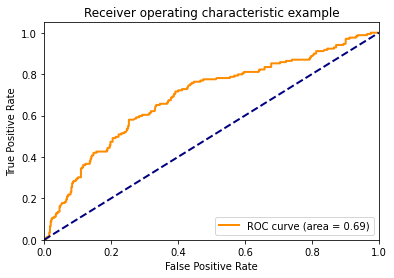

In [ ]:
# Compute ROC curve and ROC area
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test_total, y_pred_total)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()



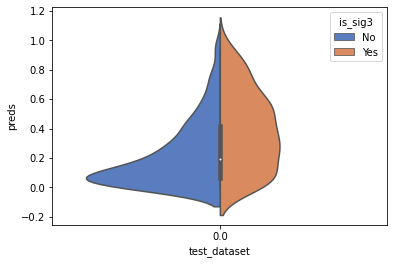

In [ ]:
# Generate a Violin Plot
violin_plot_data = pd.DataFrame()
violin_plot_data['is_sig3'] = ["Yes" if x == 1 else "No" for x in np.array(y_test_total).flatten()]
violin_plot_data['preds'] = np.array(y_pred_total).flatten()
violin_plot_data['test_dataset'] = np.zeros(len(y))
ax = sns.violinplot(x="test_dataset", y="preds", hue="is_sig3",
                    data=violin_plot_data, palette="muted", split=True)

In [ ]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 19500), started 0:08:28 ago. (Use '!kill 19500' to kill it.)

In [ ]:
!rm -rf ./logs/

### KNN Results

In [ ]:
# Threshold: 20% of Mutations 

KNN_auc_20, KNN_mad_20, KNN_model_20 = compute_mlp_performance(data_dir, model_name = 'KNN', n_folds=10, n_neighbors=2, y_col='is_sig3_20')
print(KNN_auc_20, KNN_mad_20)

# Threshold: 10% of Mutations 

KNN_auc_10, KNN_mad_10, KNN_model_10 = compute_mlp_performance(data_dir, model_name = 'KNN', n_folds=10, n_neighbors=1, y_col='is_sig3_10')
print(KNN_auc_10, KNN_mad_10)

# Threshold: 5% of Mutations 

KNN_auc_05, KNN_mad_05, KNN_model_05 = compute_mlp_performance(data_dir, model_name = 'KNN', n_folds=10, n_neighbors=1, y_col='is_sig3_05')
print(KNN_auc_05, KNN_mad_05)

# Threshold: 1% of Mutations 

KNN_auc_01, KNN_mad_01, KNN_model_01 = compute_mlp_performance(data_dir, model_name = 'KNN', n_folds=10, n_neighbors=1, y_col='is_sig3_01')
print(KNN_auc_01, KNN_mad_01)



KNN  model selected
0.6299537907268171 [0.08427669]
KNN  model selected
0.6110182088442958 [0.05948331]
KNN  model selected
0.60798638764156 [0.09898631]
KNN  model selected
0.6085982000455684 [0.06849491]


### LR Results

In [ ]:
# Threshold: 20% of Mutations 
LR_auc_20, LR_mad_20, LR_model_20 = compute_mlp_performance(data_dir, model_name = 'LR', n_folds=10, y_col='is_sig3_20')
print(LR_auc_20, LR_mad_20)

# Threshold: 10% of Mutations 
LR_auc_10, LR_mad_10, LR_model_10 = compute_mlp_performance(data_dir, model_name = 'LR', n_folds=10, y_col='is_sig3_10')
print(LR_auc_10, LR_mad_10)

# Threshold: 5% of Mutations 
LR_auc_05, LR_mad_05, LR_model_05 = compute_mlp_performance(data_dir, model_name = 'LR', n_folds=10, y_col='is_sig3_05')
print(LR_auc_05, LR_mad_05)

# Threshold: 1% of Mutations 
LR_auc_01, LR_mad_01, LR_model_01 = compute_mlp_performance(data_dir, model_name = 'LR', n_folds=10, y_col='is_sig3_01')
print(LR_auc_01, LR_mad_01)



LR  model selected
0.6440942621009758 [0.10919428]
LR  model selected
0.6139772727272728 [0.07031947]
LR  model selected
0.5660458540783084 [0.0804644]
LR  model selected
0.5816467428967429 [0.06007907]
